In [1]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
warnings.filterwarnings("ignore", message=r"Implicit", category=UserWarning)

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

from carla import log
from carla.models.negative_instances import predict_negative_instances
from carla.recourse_methods import Dice, Wachter
from copy import deepcopy
from datetime import datetime
from func_timeout import func_timeout, FunctionTimedOut
from ipynb.fs.full.dynamic_recourse import DynamicCsvCatalog, DynamicMLModelCatalog
from ipynb.fs.full.plotting import plot_distribution
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# os.environ["CUDA_VISIBLE_DEVICES"] = ""

#     torch.manual_seed(0)
#     random.seed(0)
#     np.random.seed(0)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [3]:
def k_means(data, min_clusters=1, max_clusters=10):
    """
    Applies the k-means algorithm and automatically estimates the elbow point.
    The algorithm used to calculate the elbow point is described in 10.1109/ICDCSW.2011.20
    
    Args:
        data (pandas.DataFrame): 
            Records along with their labels.
        min_clusters (int): 
            Minimal number of clusters that is expected in the dataset.
        max_clusters (int):
            Maximal number of clusters that is expected in the dataset.
        
    Returns:
        int: Estimated number of clusters that yields the elbow point on an inertia graph.
    """
    clusters = []
    scores = []
    # Fit different potential numbers of clusters
    for k in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        clusters.append(k)
        scores.append(kmeans.inertia_)   
    
    # Automatically find the elbow point, this should change at some point during the application of AR
    # if the counterfactual instances form their own cluster(s), the value returned by this method should change.
    kneedle = KneeLocator(clusters, scores, curve="convex", direction="decreasing")

    return int(kneedle.elbow)

def class_statistics(data, target, aggregate):
    """
    Applies an aggregation function for the two classes described in the dataset.
    
    Args:
        data (pandas.DataFrame):
            Records along with their labels.
        target (str): 
            Name of the target column.
        aggregate (Callable): 
            An aggregation function which can be applied on data.
        
    Returns:
        dict: Values return by the aggregation function applied on the positive and negative class.
    """
    features = data.loc[:, data.columns != target]
    positive_samples = features.loc[data[target] == positive_class]
    negative_samples = features.loc[data[target] == negative_class]
    return {"positive": aggregate(positive_samples).to_dict(), 
            "negative": aggregate(negative_samples).to_dict()}

def measure_distribution(dataset):
    """
    Computes a set of statistical measures for the distribution of a dataset.
    
    Args:
        dataset (DataCatalog):
            Catalog containing a dataframe, set of train and test records, and the target.
        
    Returns:
        dict: Statistics calculated for a specific distribution of data.
    """
    num_clusters = k_means(dataset.df.loc[:, dataset.df.columns != dataset.target].to_numpy())
    means = class_statistics(dataset.df, dataset.target, np.mean)
    stds = class_statistics(dataset.df, dataset.target, np.std)
    
    return {"num_clusters": num_clusters, "means": means, "stds": stds}

In [4]:
def train_model(dataset, hyper_params, model_type='ann', retrain=False):
    """
    Instantiates and trains a black-box model within a CARLA wrapper that will be used to generate explanations.
    
    Args:
        dataset (DataCatalog): 
            Catalog containing a dataframe, set of train and test records, and the target.
        hyper_params (dict): 
            Dictionary storing all custom hyper-parameter values for the model.
        
    Returns:
        MLModelCatalog: 
            Classifier with additional utilities required by CARLA.
    """
    kwargs = {'save_name_params': "_".join([str(size) for size in hyper_params['hidden_size']])}
    model = DynamicMLModelCatalog(dataset, model_type=model_type,
                                  load_online=False, backend="pytorch", **kwargs)

    # force_train is enabled to ensure that the model is not reused from the cache
    if not retrain:
        log.info("Training the initial model")
        model.train(learning_rate=hyper_params['learning_rate'],
                    epochs=hyper_params['epochs'],
                    batch_size=hyper_params['batch_size'],
                    hidden_size=hyper_params['hidden_size'],
                    force_train=True)
    else:
        model.retrain(learning_rate=hyper_params['learning_rate'],
                      epochs=hyper_params['epochs'],
                      batch_size=hyper_params['batch_size'])
    
    return model

In [5]:
def performance(dataset, model):
    """
    Computes a set of performance metrics for a classifier.
    
    Args:
        dataset (DataCatalog): 
            Catalog containing a dataframe, set of train and test records, and the target.
        model (MLModelCatalog) 
            Classifier with additional utilities required by CARLA.
    
    Returns:
        dict: A dictionary of statistical measurements of the model performance.
    """
    predictions = model.predict_proba(dataset.df_test.loc[:, dataset.df_test.columns != dataset.target])
    predicted_labels = np.argmax(predictions, axis=1) 
    ground_truth = dataset.df_test.loc[:, dataset.df_test.columns == dataset.target].values.astype(int).flatten() 
    
    return {
        "acc": accuracy_score(ground_truth, predicted_labels),
        "f1": f1_score(ground_truth, predicted_labels)
    }

In [6]:
def recourse_worker(generator, factual):
    """
    Apply algorithmic recourse for a (set of) factuals using a chosen generator.
    
    Args:
        generator (RecourseMethod): 
            Generator that finds counterfactual explanations using a black-box model.
        factual (pandas.DataFrame): 
            One or more records from a dataset used to train the black-box model.
        
    Returns:
        pandas.DataFrame: A counterfactual explanation for the provided factual.
    """
    if factual is None:
        raise ValueException('Provided with a non-existent factual')
        return None
    
    counterfactuals = generator.get_counterfactuals(factual).dropna()
    if not counterfactuals.empty:
        return counterfactuals.sample().astype(float)
    raise FunctionTimedOut()
    
def recourse_controller(function, max_wait_time, generator, factual):
    """
    Wrapper function that ensures the application of recourse does not run indefinitely.
    
    Args:
        function (Callable): 
            Function that will have its execution placed under a timeout.
        max_wait_time (int): 
            Number of seconds after which the `function` will time out.
        generator (RecourseMethod): 
            Generator that finds counterfactual explanations using a black-box model.
        factual (pandas.DataFrame): 
            One or more records from a dataset used to train the black-box model.
        
    Returns:
        pandas.DataFrame: A counterfactual explanation for the provided factual if found.
    """
    try:
        return func_timeout(max_wait_time, function, args=[generator, factual]) 
    except FunctionTimedOut:
        log.info("Timeout - No Counterfactual Explanation Found")

    return None

In [7]:
def plot_distribution(data, output_directory, generator_name, plot_name, plot_id, show_plot=False):
    """
    Generates a plot a two-class dataset and saves it to a file.
    
    Args:
        data (pandas.DataFrame): 
            Records along with their labels.
        output_directory (str): 
            Name of the directory where images are saved.
        generator_name (str): 
            Name of the applied recourse generator.
        plot_name (str): 
            Type of the created plot.
        plot_id (str): 
            ID for the generated plot (e.g. consecutive numbers for different distributions).
        show_plot (Boolean): 
            If True the plot will also be outputted directly to the notebook.
    """
    colors = np.array(['#1f77b4', '#ff7f0e'])
    plt.scatter(data['feature1'], data['feature2'], c=colors[data['target'].astype(int)])
    
    plt.axis('equal')
    plt.grid(True)
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.3, 1.3])
    
    plt.suptitle(f'Recourse generated by {generator_name.upper()}')
    plt.savefig(f"{output_directory}/{generator_name}_{plot_name}_{f'{plot_id:06}'}.png", bbox_inches='tight')
    
    if show_plot:
        plt.show()
        
    plt.close()

In [8]:
# TODO: Generalize for other recourse generators
# TODO: What to do if a generator times out? do we accept different numbers of samples?
# TODO: Create a wrapper for RecourseMethod to allow for the measurement of multiple generators at once
class RecourseExperiment():
    """
    Allows to conduct an experiment about the dynamics of algorithmic recourse.
    
    Attributes:
        dataset (DataCatalog): 
            Catalog containing a dataframe, set of train and test records, and the target.
        generator_name (str):
            Name of the generator that is placed under test.
        generator_timeout (int): 
            Number of seconds after which the search for counterfactuals will time out.
        experiment_name (str):
            Name of the experiment that will be used as part of the directory name where results are saved.
        kwargs (dict):
            Dictionary of optional keyworded arguments.  
    """
    
    def __init__(self, dataset, total_recourse=0.5, recourse_per_epoch=0.01, generator_name='DICE',
                 generator_timeout=3, experiment_name='experiment', **kwargs):
    
        # Experiment data is saved into a new directory
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        self.experiment_name = f'{timestamp}_{experiment_name}'
        os.makedirs(f'../experiment_data/{self.experiment_name}')
        self.generator_name = generator_name
        self.generator_timeout = generator_timeout

        self.experiment_data = {
            self.generator_name: {0: {}},
            'wachter': {0: {}}
        }

        # Train a classifier on the dataset
        self.hyper_params = kwargs.get('hyper_params',
                                       {'learning_rate': 0.04, 'epochs': 3, 'batch_size': 1, 'hidden_size': [4]})
        self.dataset = dataset
        self.model = train_model(dataset, self.hyper_params)
        self.initial_model = deepcopy(self.model)

        # Recourse generated by DICE is compared with the Wachter generator, as they may modify data differently
        # we need to keep track of two models and two datasets and update them independently
        self.benchmark_dataset = deepcopy(dataset)
        self.benchmark_model = deepcopy(self.model)

        # factuals are a list of instances that the model expects to belong to the negative class;
        # in order to acurately measure the performance of the dataset we never change the test set
        self.factuals = predict_negative_instances(self.model, dataset.df_train)
        self.factuals_index = self.factuals.index.tolist()

        # Instantiate recourse generators
        self.dice_params = kwargs.get('generator_params', {"num": 1})
        self.benchmark_params = kwargs.get('benchmark_params', {"loss_type": "BCE", "t_max_min": 0.5})
        
        self.generator = Dice(self.model, self.dice_params)
        self.benchmark = Wachter(self.benchmark_model, self.benchmark_params)
        
        pos_individuals = dataset.df_train.loc[dataset.df_train['target'] == positive_class]
        neg_individuals = dataset.df_train.loc[dataset.df_train['target'] == negative_class]
        self.initial_pos_sample = pos_individuals.sample(n=min(len(pos_individuals), 100)).to_numpy()
        self.initial_neg_sample = neg_individuals.sample(n=min(len(neg_individuals), 100)).to_numpy() 
            
    def run(self, total_recourse=0.8, recourse_per_epoch=0.01):
        """
        Driver code to execute an experiment that allows to compare the dynamics of recourse 
        applied by some generator to a benchmark described by Wachter et al. (2017).
        
        Attributes:
            total_recourse (float): 
                Value between 0 and 1 representing the proportion of samples from the training set
                which should have recourse applied to them throughout the experiment.
            recourse_per_epoch (float): 
                Value between 0 and 1 representing the proportion of samples from the training set
                which should have recourse applied to them in a single iteration.
        """
    
        num_found_generator = 0
        num_found_benchmark = 0
           
        # Measure the data distribution and performance of models
        self.measure(0)
        
        # Plot initial data distributions
        path = f'../experiment_data/{self.experiment_name}'
        plot_distribution(self.dataset._df, path, self.generator_name, 'distribution', 0)
        plot_distribution(self.benchmark_dataset._df, path, 'wachter', 'distribution', 0)
        
#         sns_distribution(self.benchmark_dataset._df, path, 'wachter', 'distribution', 0)
        
        # Convert ratio of samples that should undergo recourse in a single epoch into a number
        recourse_per_epoch = max(int(recourse_per_epoch * len(self.factuals)), 1)
        # Convert ratio of samples that should undergo recourse in total into a number of epochs
        epochs = max(int(min(total_recourse, 1) * len(self.factuals) / recourse_per_epoch), 1)
                              
        for epoch in range(epochs - 1):
            log.info(f"Starting epoch {epoch + 1}")
            self.experiment_data[self.generator_name][epoch + 1] = {}
            self.experiment_data['wachter'][epoch + 1] = {}
                              
            # 4. Generate a subset S of factuals that have never been encountered by the generators
            sample_size = min(recourse_per_epoch, len(self.factuals_index))
            current_factuals_index = np.random.choice(self.factuals_index, replace=False, size=sample_size)
            current_test_factuals = self.dataset._df.iloc[current_factuals_index]
            current_benchmark_factuals = self.benchmark_dataset._df.iloc[current_factuals_index] 
                              
            # We do not want to accidentally generate a counterfactual from a counterfactual
            self.factuals_index = [f for f in self.factuals_index if f not in current_factuals_index]  

            # Apply recourse for S with DICE
            num_found_generator += self.apply_recourse_with_timeout(self.dataset,
                                                                    current_test_factuals,
                                                                    self.generator)

            # Update DICE model
            self.model = self.update_model(self.dataset, self.model, self.generator_name)


            # Apply recourse for S with Wachter
            num_found_benchmark += self.apply_recourse(self.benchmark_dataset,
                                                       current_benchmark_factuals,
                                                       self.benchmark)
            
            # Update the Wachter model
            self.benchmark_model = self.update_model(self.benchmark_dataset, self.benchmark_model, 'Wachter')
                           
            # Measure the data distribution and performance of models
            self.measure(epoch + 1)

            # Plot data distributions
            plot_distribution(self.dataset._df, path, self.generator_name, 'distribution', epoch + 1)
            plot_distribution(self.benchmark_dataset._df, path, 'wachter', 'distribution', epoch + 1)
            
            sns_distribution(self.dataset._df, self.benchmark_model, path, 'wachter', 'distribution', epoch + 1)
            
            self.generator = Dice(self.model, self.dice_params)
            self.benchmark = Wachter(self.benchmark_model, self.benchmark_params)

        # Measure the quality of recourse
        self.experiment_data['evaluation'] = {
            'dice': {
                'success_rate': num_found_generator / max(len(self.factuals.index) - len(self.factuals_index), 1)
            },
            'wachter': {
                'success_rate': num_found_benchmark / max(len(self.factuals.index) - len(self.factuals_index), 1)
            }
        }
        
        print(current_MMD(self.benchmark_dataset._df_train, self.initial_pos_sample, self.initial_neg_sample))

    def measure(self, epoch):
        """
        Quantify the dataset and model and save into `experiment_data`.
        
        Args:
            epoch (int): 
                Current epoch in the experiment.
        """     
        # Measure the distributions of data
        self.experiment_data[self.generator_name][epoch]['distribution'] = measure_distribution(self.dataset)
        self.experiment_data['wachter'][epoch]['distribution'] = measure_distribution(self.benchmark_dataset)

        # Measure the current performance of models
        self.experiment_data[self.generator_name][epoch]["performance"] = performance(self.dataset,
                                                                         self.model)
        self.experiment_data['wachter'][epoch]["performance"] = performance(self.benchmark_dataset,
                                                                            self.benchmark_model)   
        
        # Measure the disagreement between current models and the initial model
        generator_disagreement = disagreement_distance(self.dataset._df_test, self.dataset.target,
                                                       self.initial_model, self.model)
        self.experiment_data[self.generator_name][epoch]['disagreement'] = generator_disagreement
        
        benchmark_disagreement = disagreement_distance(self.dataset._df_test, self.dataset.target,
                                                       self.initial_model, self.benchmark_model)
        self.experiment_data['wachter'][epoch]['disagreement'] = generator_disagreement
        
        # Measure the MMD
        self.experiment_data[self.generator_name][epoch]['MMD'] = current_MMD(self.dataset._df_train,
                                                                              self.initial_pos_sample,
                                                                              self.initial_neg_sample)
        
        self.experiment_data['wachter'][epoch]['MMD'] = current_MMD(self.benchmark_dataset._df_train,
                                                                    self.initial_pos_sample,
                                                                    self.initial_neg_sample)
                         
            
    def update_model(self, dataset, model, generator_name):
        """
        Re-train the model based on an updated dataset
        
        Args:
            dataset (DataCatalog): 
                Catalog containing a dataframe, set of train and test records, and the target.
            model (MLModelCatalog) 
                Classifier with additional utilities required by CARLA.
            generator_name (str):
                Name of the generator that has its model updated.
                
        Returns:
            MLModelCatalog: A re-trained classifier.
        """
        # Ensure that the dataset saved by the model is always updated with counterfactuals
        model.data._df.update(dataset._df)
        model.data._df_train.update(dataset._df)
                              
        log.info(f'Updating the {generator_name} model')                      
        return train_model(dataset, hyper_params, retrain=True)                    
        
                                    
    def apply_recourse(self, dataset, factuals, generator, generator_name='Wachter'):
        """
        Generate (a set of) counterfactual explanations with a provided generator.
        
        Args:
            dataset (DataCatalog): 
                Catalog containing a dataframe, set of train and test records, and the target.
            factuals (pandas.DataFrame): 
                One or more records from a dataset used to train the black-box model.
            generator (RecourseMethod): 
                Generator that finds counterfactual explanations using a black-box model.
            generator_name (str):
                Name of the generator that is used to apply recourse.
                
        Returns:
            int: Number of successfully generated counterfactuals.
        """
        log.info(f"Applying the {generator_name} generator.")
        
        if factuals is None or len(factuals) == 0:
            return 0
                                              
        counterfactuals = generator.get_counterfactuals(factuals).dropna()
        dataset._df.update(counterfactuals)
        
        return len(counterfactuals.index)
  
                              
    def apply_recourse_with_timeout(self, dataset, factuals, generator, generator_name='DICE'):
        """
        Generate (a set of) counterfactual explanations with a provided generator. 
        These explanations are applied one-by-one with a specific timeout for every single factual.
        
        Args:
            dataset (DataCatalog): 
                Catalog containing a dataframe, set of train and test records, and the target.
            factuals (pandas.DataFrame): 
                One or more records from a dataset used to train the black-box model.
            generator (RecourseMethod): 
                Generator that finds counterfactual explanations using a black-box model.
            generator_name (str):
                Name of the generator that is used to apply recourse.
                
        Returns:
            int: Number of successfully generated counterfactuals.
        """
        log.info(f"Applying the {generator_name} generator.")
        
        if factuals is None or len(factuals) == 0:
            return 0
                              
        counterfactuals_found = 0
        for i in range(len(factuals)):
            f = factuals.iloc[[i]]
            
            log.info(f"Generating counterfactual {i + 1} with {generator_name}")
            # CARLA does not implement a timeout for the generators by default
            # but we want to prevent the code from running indefinitely
            counterfactuals = recourse_controller(recourse_worker, self.generator_timeout, generator, f)
            # We only want to overwrite the existing data if counterfactual generation was successful
            if counterfactuals is not None and not counterfactuals.empty:
                dataset._df.iloc[f.index[0]] = counterfactuals.iloc[0]
                counterfactuals_found += 1
                         
        return counterfactuals_found
                
                         
    def save_data(self, path=None):
        """
        Write the data collected throughout the experiment into a .json file.
        """
        
        path = path or f'../experiment_data/{self.experiment_name}/measurements.json'
        with open(path, 'w') as outfile:
            json.dump(self.experiment_data, outfile, sort_keys=True, indent=4)

In [9]:
from sklearn.gaussian_process.kernels import RBF

def MMD(x, y, scale=0.5):
    """
    Calculates the Maximum Mean Discrepancy (MMD) between sets of samples from two probability distribution.
    MMD = ||µp - µq||^{2}_{H} where µp, µq are mean embeddings in H, a Reproducing Kernel Hilbert Space.
    This can be used either per class (which may be more suitable to assess shifts) or on the whole dataset.
    
    Args:
        x (numpy.ndarray):
            An n-dimensional sample of length `l` from the first distribution.
        y (numpy.ndarray):
            An n-dimensional sample of length `l` from the second distribution.
        scale (float):
            Length-scale of the kernel, influences the smoothness of the transformation.
            
    Returns:
        float: Measure of distance between two distributions (0 means distributions are the same).
    """
    
    # RBF is the Gaussian kernel allowing to embed the distribution in RKHS
    # As e^x = 1 + x + (1 / 2!) * x^2 ... we can capture all moments of the distribution
    k = RBF(length_scale = scale)
    
    # Implementation of Equation (3) from https://arxiv.org/pdf/1810.11953.pdf
    m, n = len(x), len(y)
    
    # We apply the kernel trick to get an unbiased empirical estimate of the squared population MMD
    Kxx = 1 / (m ** 2 - m) * (np.sum(k(x, x)) - np.trace(k(x, x)))
    Kxy = 2 / (m * n) * np.sum(k(x, y))
    Kyy = 1 / (n ** 2 - n) * (np.sum(k(y, y)) - np.trace(k(y, y)))
    
    return Kxx + Kyy - Kxy

In [10]:
def current_MMD(data, initial_pos, initial_neg):
    """
    Measure the MMD between the initial distribution and the current distribution for both classes.
    
    Args:
        data (pandas.DataFrame):
            Records along with their labels.
        initial_pos (numpy.ndarray):
            A sample of points of the positive class from the initial distribution.
        initial_neg (numpy.ndarray):
            A sample of points of the negative class from the initial distribution.
            
    Returns:
        dict: A dictionary containing current values of MMD for the positive and the negative class.
    """
    
    # Find individuals of both classes
    pos_individuals = data.loc[data['target'] == positive_class]
    neg_individuals = data.loc[data['target'] == negative_class]
    
    # Sample individuals of both classes
    # TODO this will fail if 100 individuals are not left
    updated_pos = pos_individuals.sample(n=min(len(pos_individuals), 100)).to_numpy()
    updated_neg = neg_individuals.sample(n=min(len(neg_individuals), 100)).to_numpy() 
    print(MMD(initial_pos, updated_pos), MMD(initial_neg, updated_neg))
    return {
        'positive': MMD(initial_pos, updated_pos),
        'negative': MMD(initial_neg, updated_neg)
    }

In [11]:
def disagreement_distance(data, target, initial_model, updated_model):
    """
    Calculates the Disagreement pseudo-distance defined in https://doi.org/10.1145/1273496.1273541
    as Pr(h(x) != h'(x)), that is the probability that labels assigned by one classifier do not agree
    with the labels assigned by another classifier. Simply put, it measures the overlap between models.
    As this is an empirical measure, we can vary the number of records in `data`.
    
    Args:
        data (pandas.DataFrame):
            A withheld set of records that should be predicted by the models (test set).
        target (str):
            The target column in the dataset.
        initial_model (MLModelCatalog):
            A model which was trained before recourse has been applied.
        updated_model (MLModelCatalog):
            A model retrained on a dataset with induced recourse.
            
    Returns:
        float: Probability that the two classifiers disagree on the label of a sample.
    """
    
    # Check how the initial model would assign labels to the test set
    initial_pred = np.argmax(initial_model.predict_proba(data.loc[:, data.columns != target]), axis=1)
    
    # Check how the updated model would assign labels to the test set
    updated_pred = np.argmax(updated_model.predict_proba(data.loc[:, data.columns != target]), axis=1)
    
    # Find the disagreement pseudo-distance
    return (len(initial_pred) - len(np.intersect1d(initial_pred, updated_pred))) / len(initial_pred)

In [12]:
# Load the dataset from a csv file
dataset = DynamicCsvCatalog(file_path="../datasets/unimodal_dataset_1.csv", 
                            continuous=['feature1', 'feature2'], categorical=[],
                            immutables=[], target='target', test_size=0.2)

# Encoding of the classes applied in the dataset
positive_class = 1
negative_class = 0

[INFO] Training the initial model [1759321329.py train_model]
balance on test set 0.48125, balance on test set 0.575
Epoch 0/3
----------
train Loss: 0.1811 Acc: 0.9438

test Loss: 0.0154 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0093 Acc: 1.0000

test Loss: 0.0045 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0039 Acc: 1.0000

test Loss: 0.0015 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0016 Acc: 1.0000

test Loss: 0.0020 Acc: 1.0000

-0.0017502266141327105 -0.0012177756995688238
-0.0017502266141327105 -0.0012177756995681577
[INFO] Starting epoch 1 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.4875, test set 0.575 [dynamic_recourse.ipynb retrain]

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


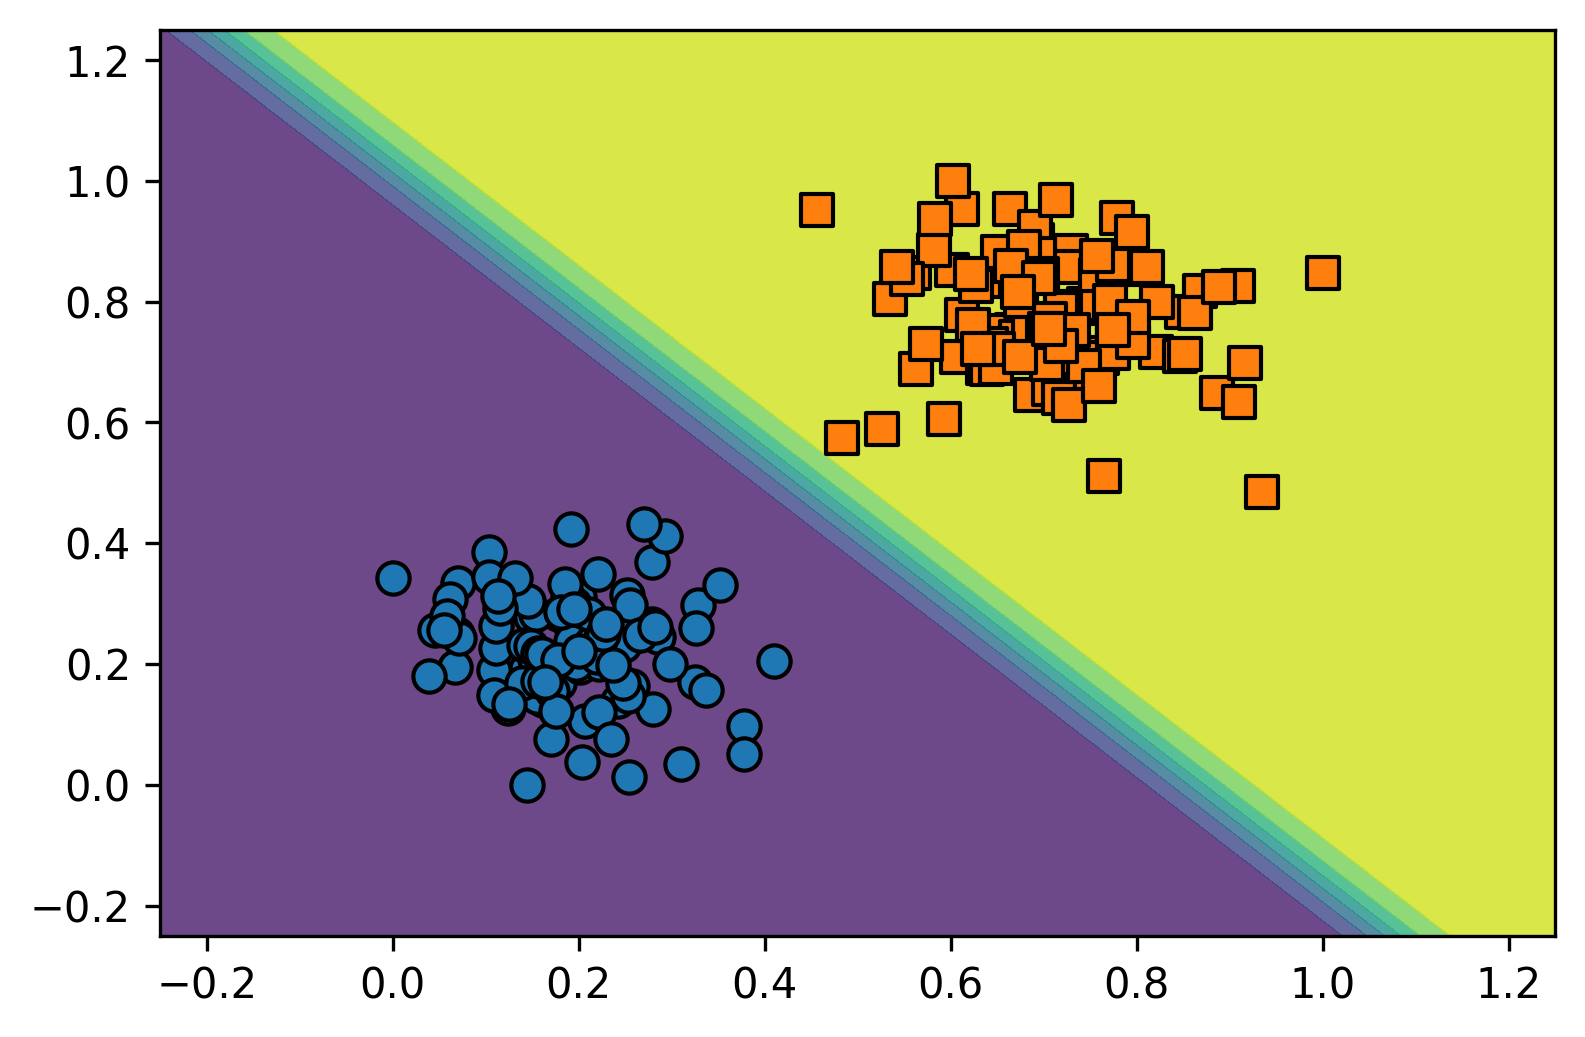

[INFO] Starting epoch 2 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.49375, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0002 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0023 Acc: 1.0000

test Loss: 0.0022 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0057 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


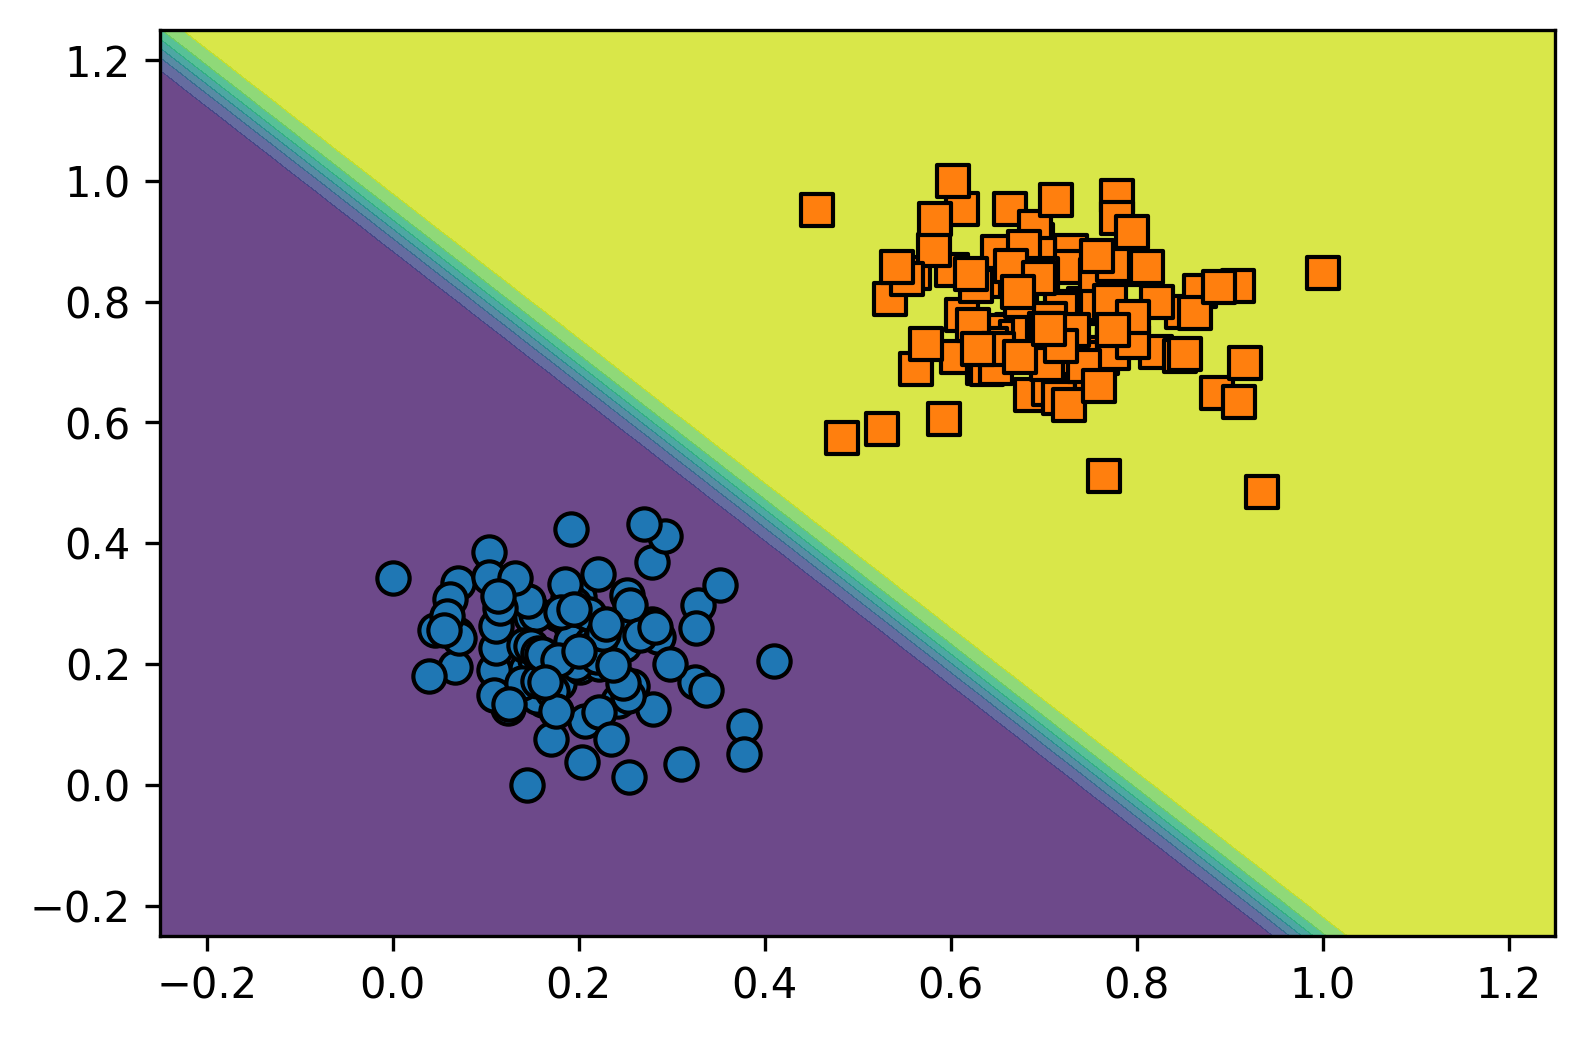

[INFO] Starting epoch 3 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.5, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0002 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded mod

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


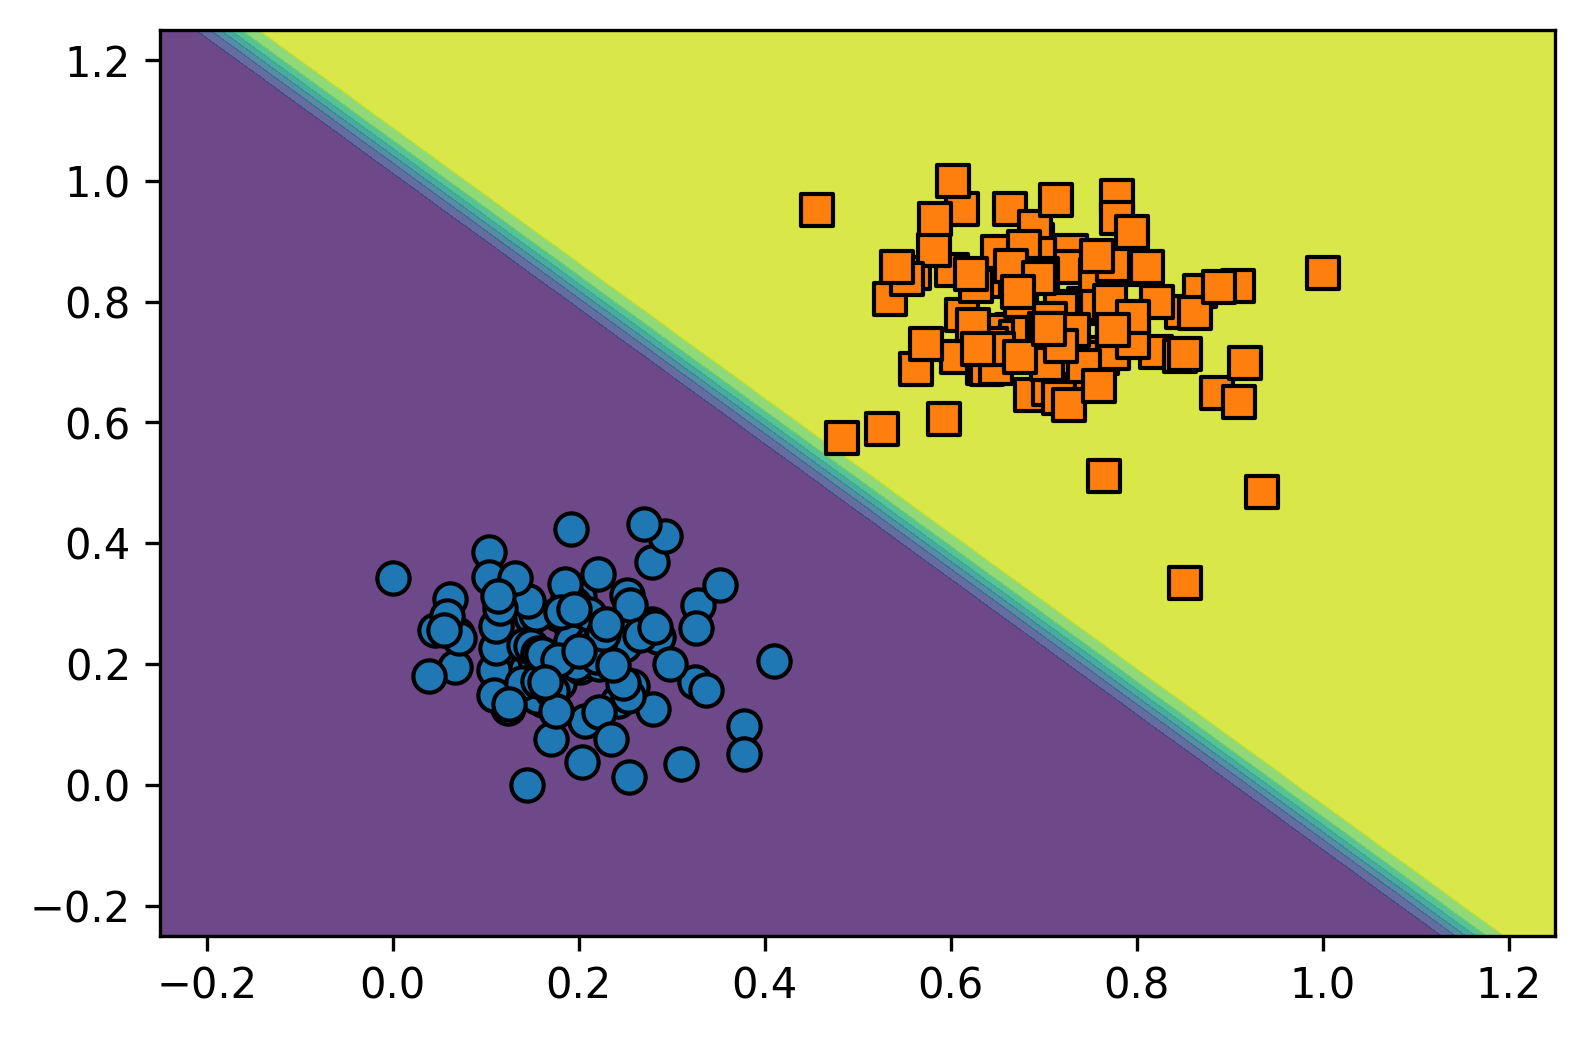

[INFO] Starting epoch 4 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.50625, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0018 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


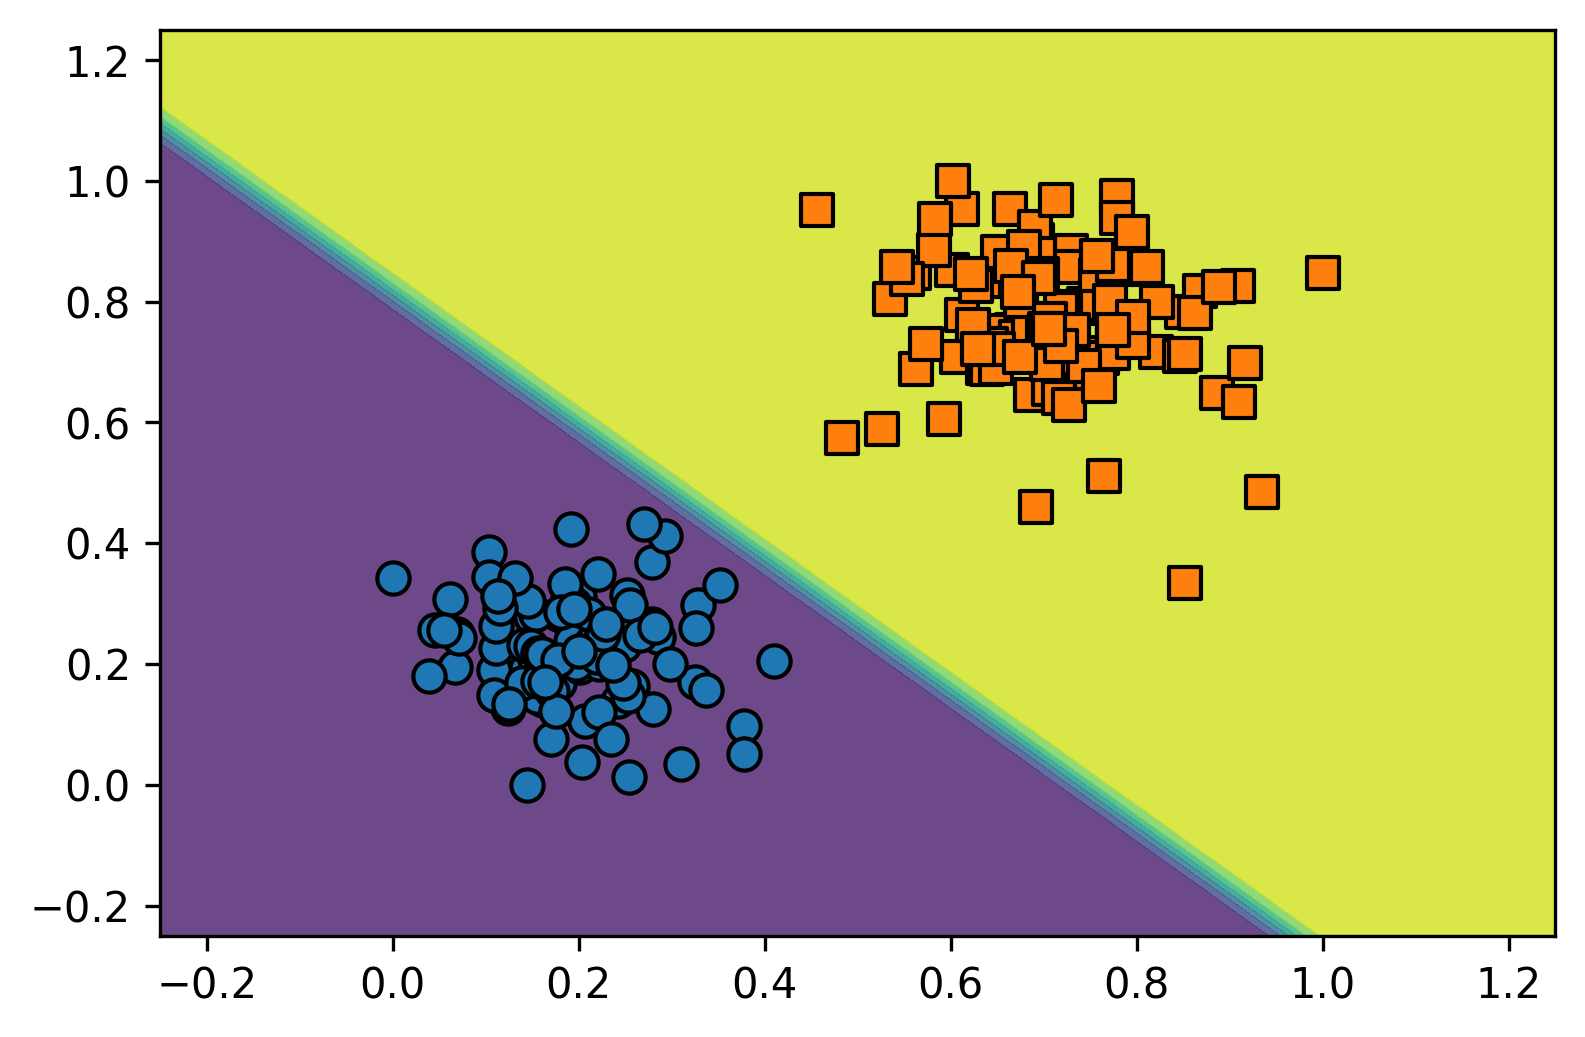

[INFO] Starting epoch 5 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Timeout - No Counterfactual Explanation Found [3910937888.py recourse_controller]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.50625, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0004 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


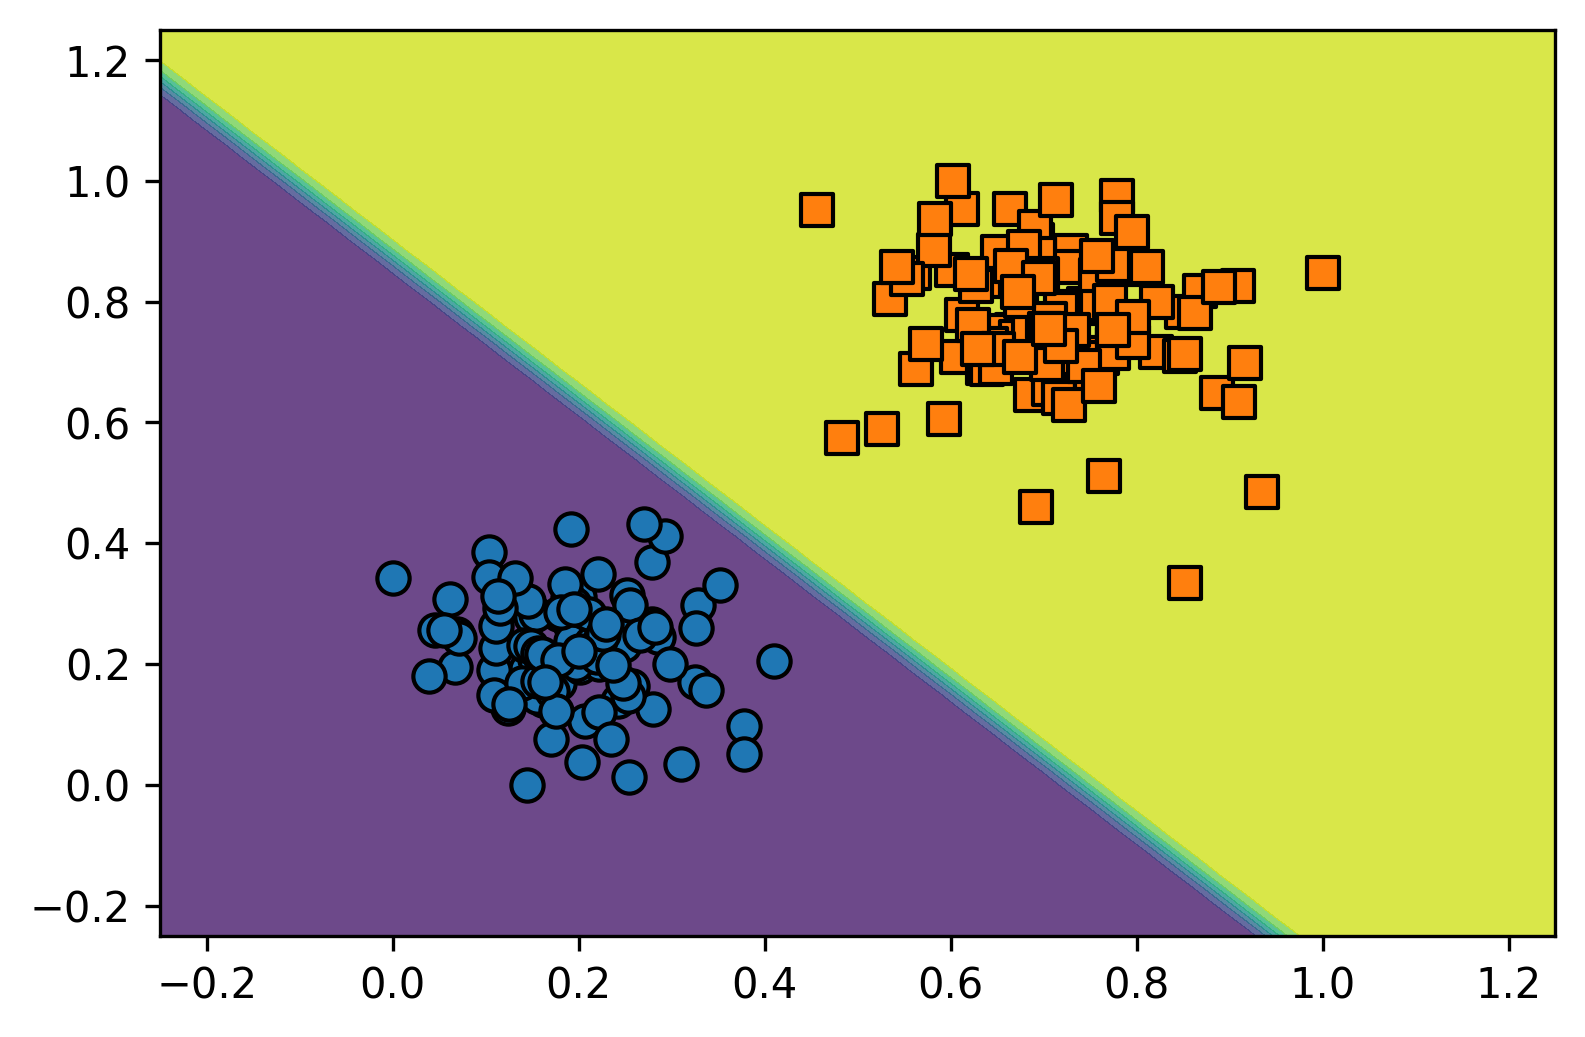

[INFO] Starting epoch 6 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.5125, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0001 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded 

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


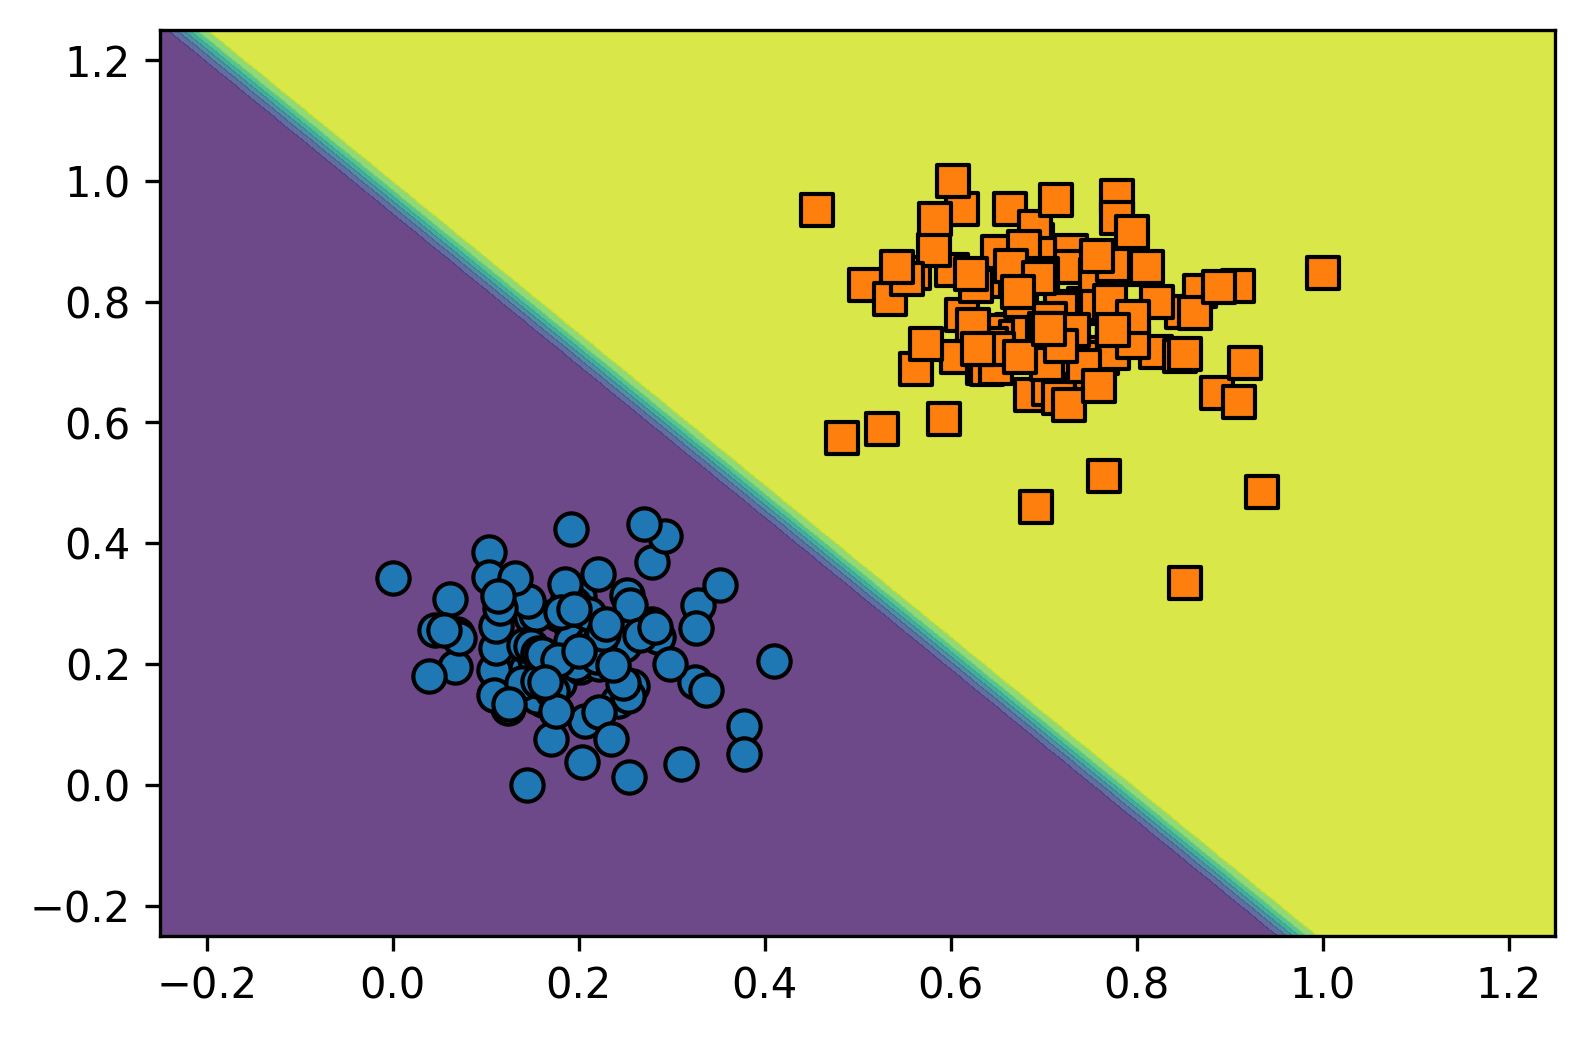

[INFO] Starting epoch 7 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.51875, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0021 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


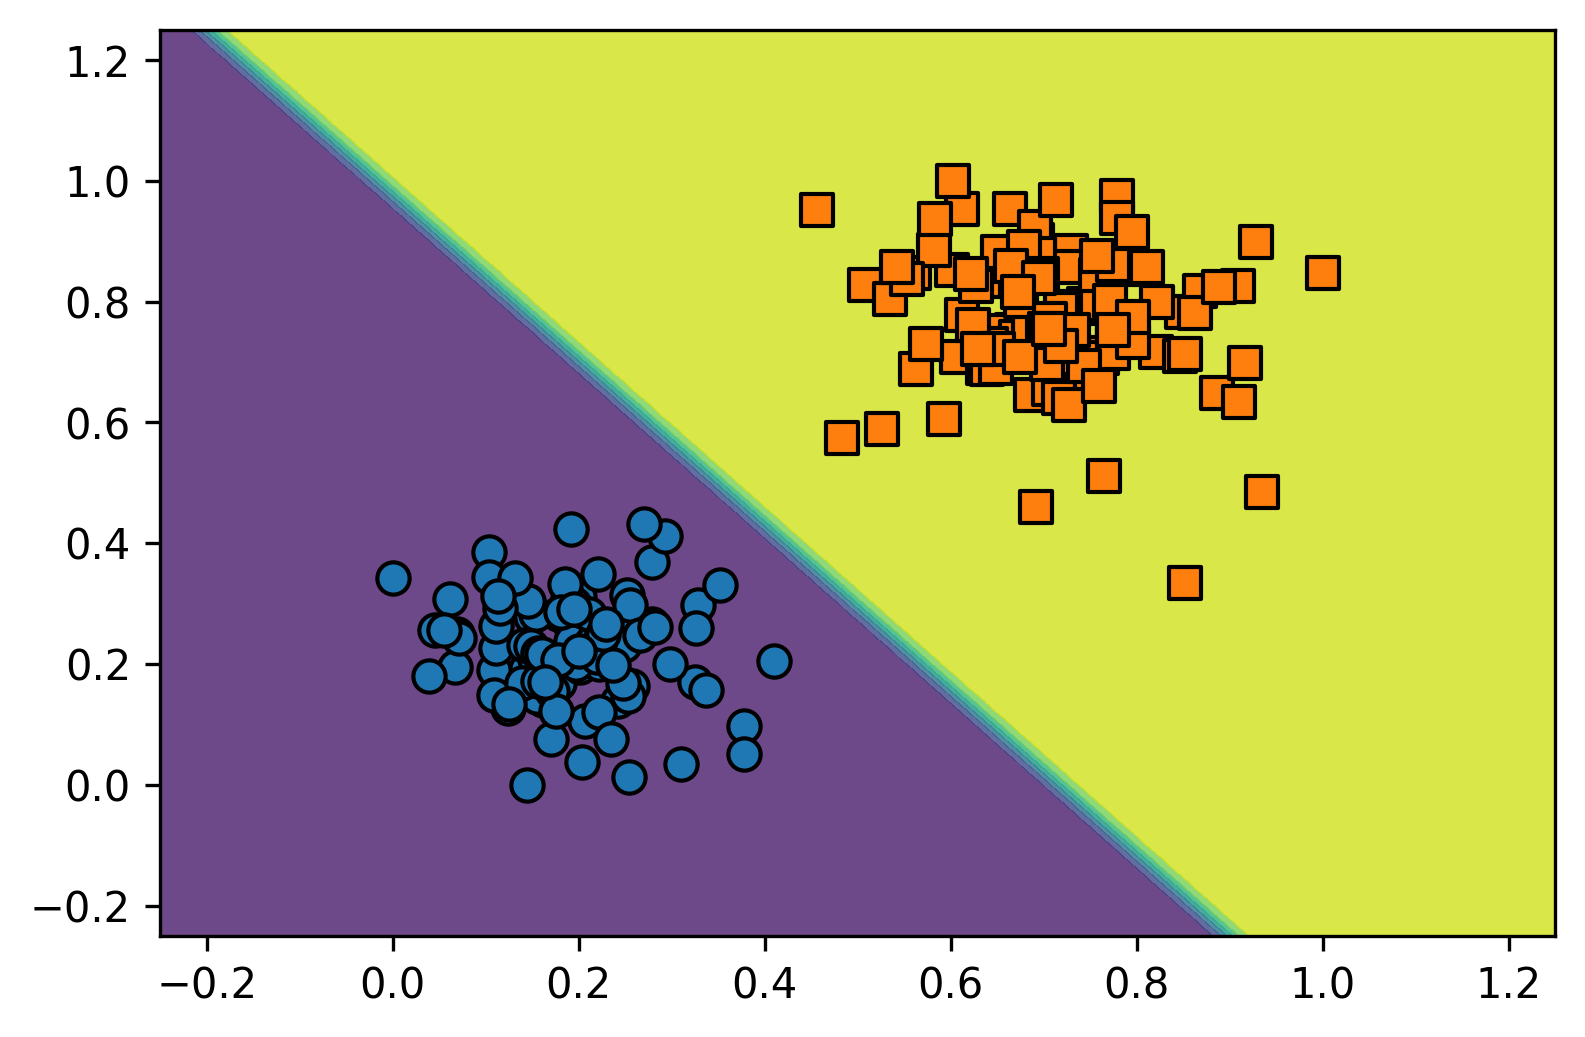

[INFO] Starting epoch 8 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.525, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded m

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


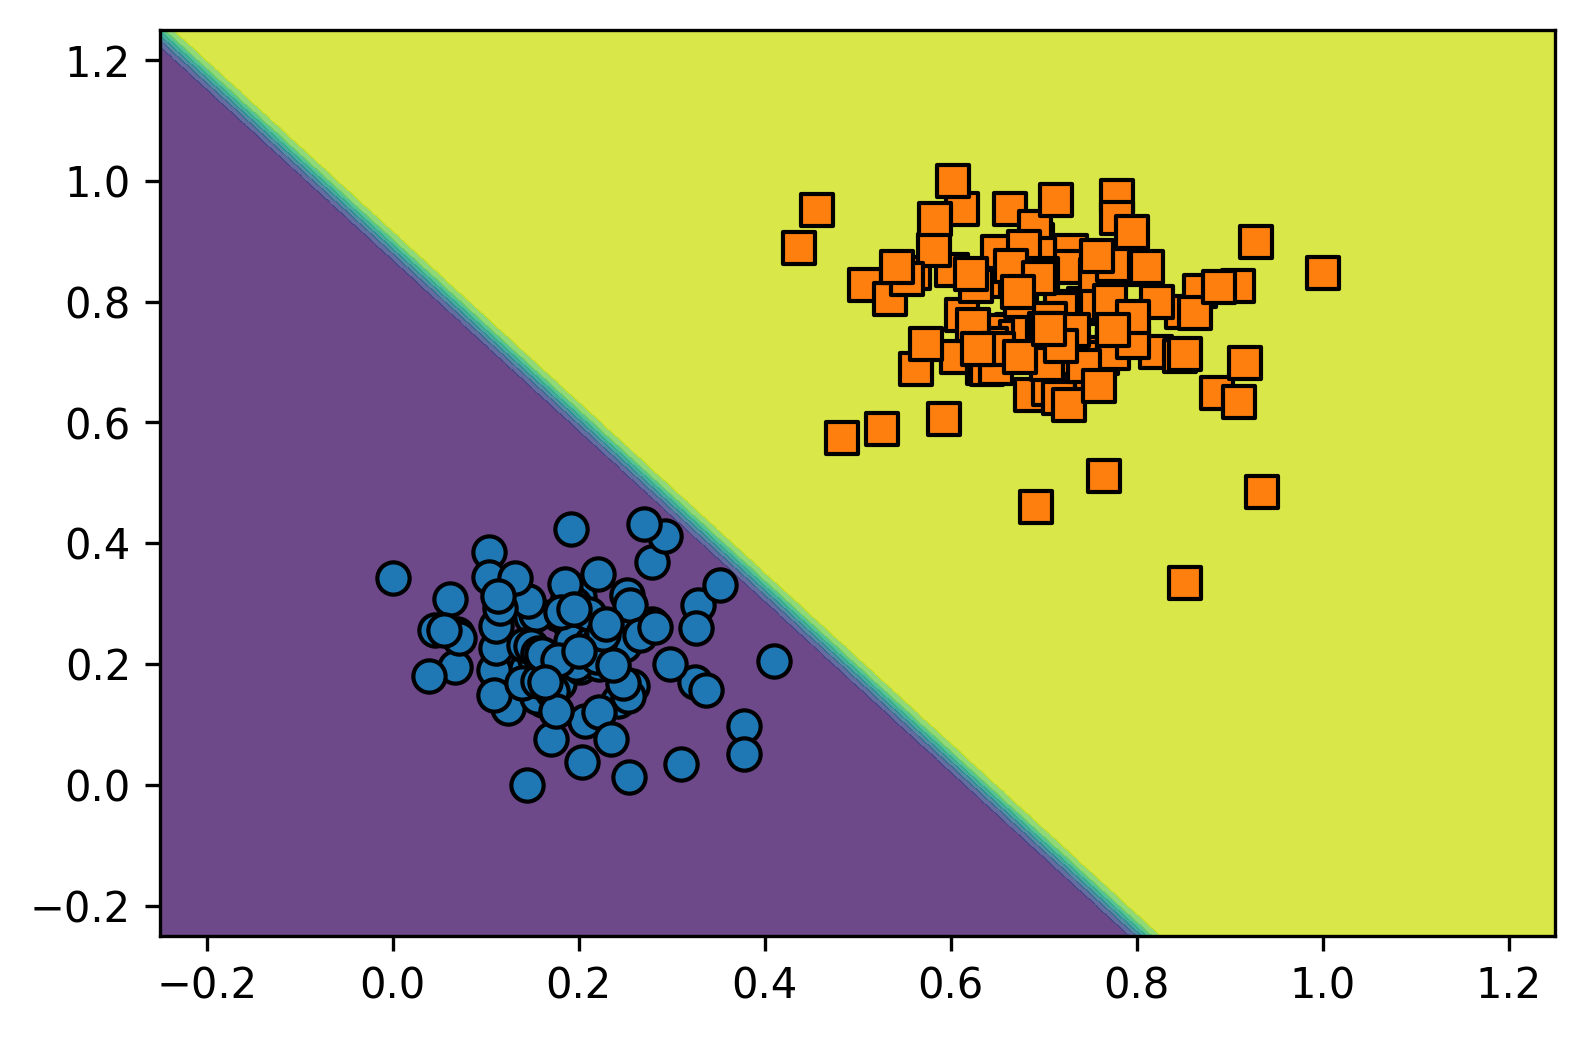

[INFO] Starting epoch 9 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.53125, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


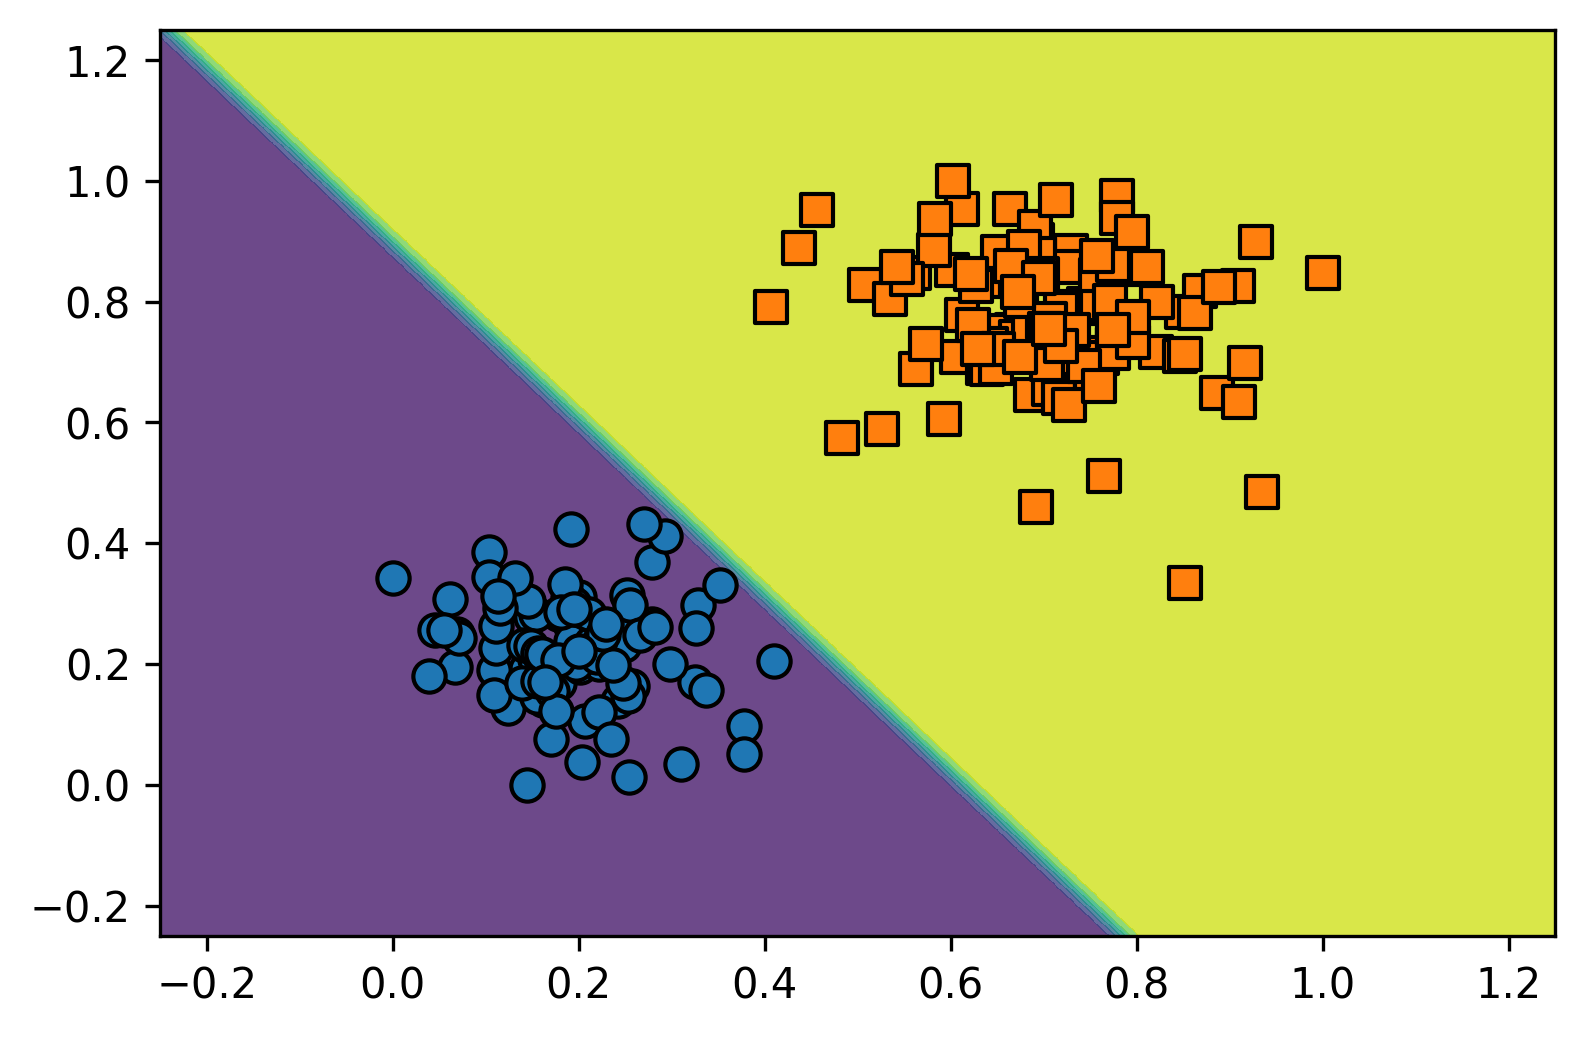

[INFO] Starting epoch 10 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.5375, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


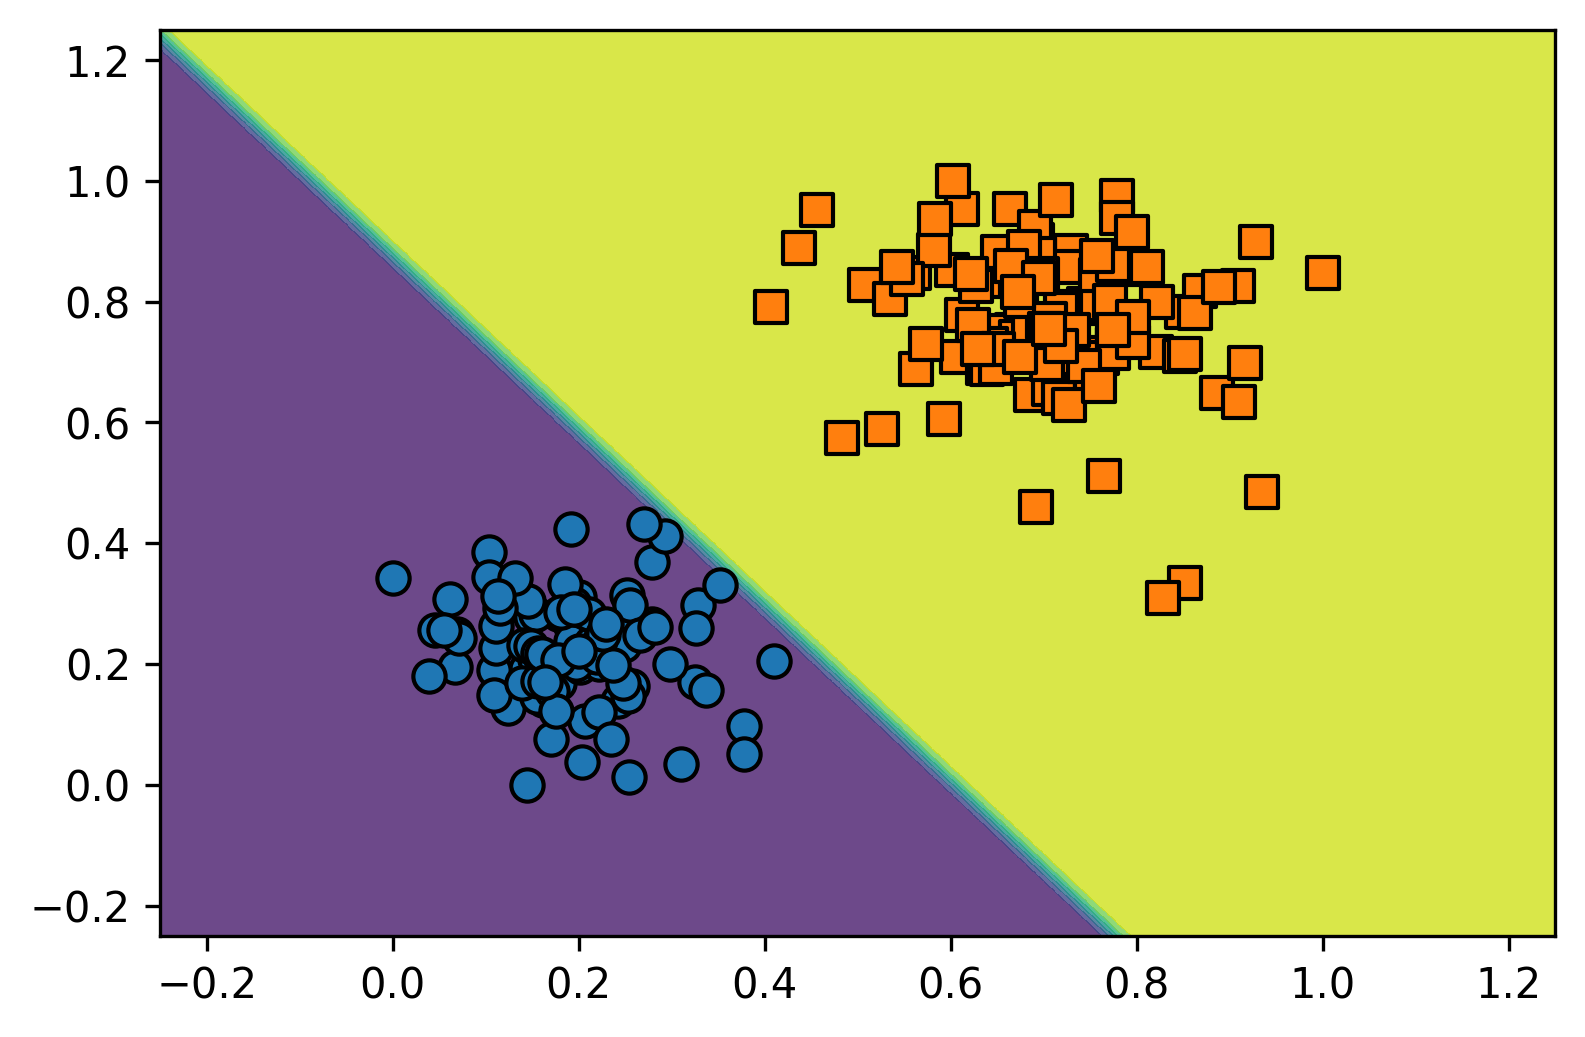

[INFO] Starting epoch 11 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.54375, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loade

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


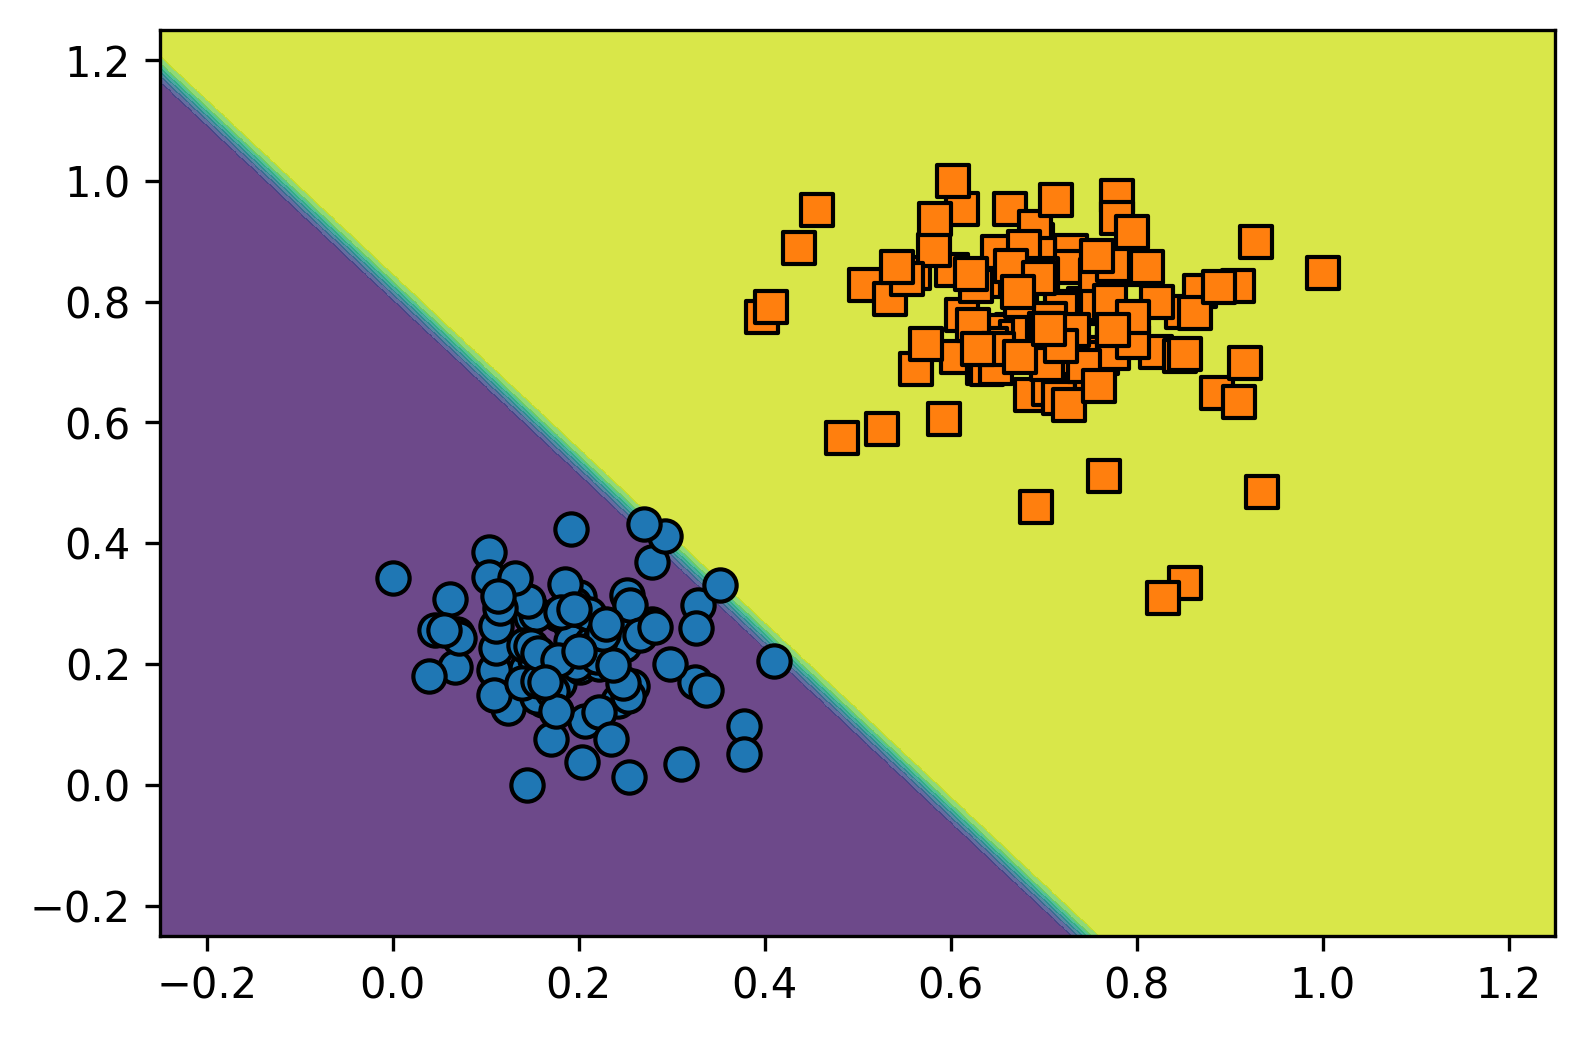

[INFO] Starting epoch 12 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.55, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0045 Acc: 0.9938

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loaded m

C:\Users\Olek\anaconda3\envs\rp\lib\site-packages\carla\models\api\mlmodel.py:153: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"


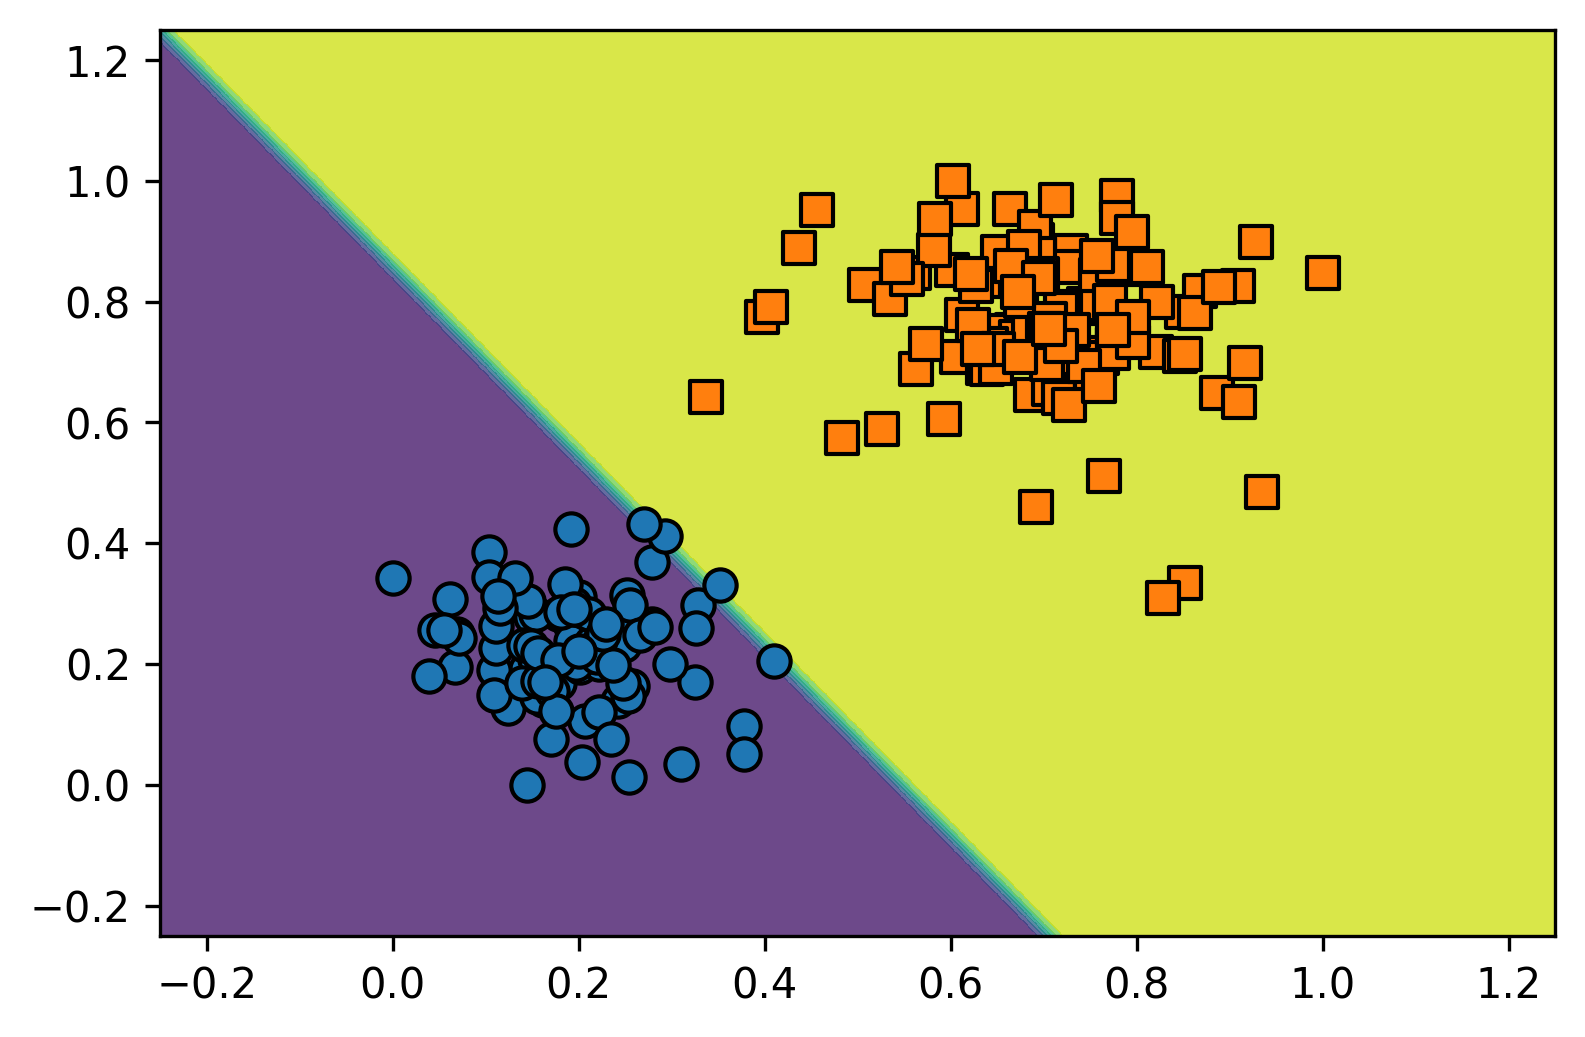

[INFO] Starting epoch 13 [542554573.py run]
[INFO] Applying the DICE generator. [542554573.py apply_recourse_with_timeout]
[INFO] Generating counterfactual 1 with DICE [542554573.py apply_recourse_with_timeout]
[INFO] Updating the DICE model [542554573.py update_model]
Loaded model from C:\Users\Olek\carla\models\custom\ann_layers_4.pt
test accuracy for model: 1.0
[INFO] Current balance: train set 0.55625, test set 0.575 [dynamic_recourse.ipynb retrain]
Epoch 0/3
----------
train Loss: 0.0402 Acc: 0.9938

test Loss: 0.0000 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0000 Acc: 1.0000

test Loss: 0.0000 Acc: 1.0000

[INFO] Applying the Wachter generator. [542554573.py apply_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Updating the Wachter model [542554573.py update_model]
Loade

In [ ]:
hyper_params = {'learning_rate': 0.04, 'epochs': 4, 'batch_size': 1, 'hidden_size': [4]}
dice_params = {"num": 3}
wachter_params = {"loss_type": "BCE", "t_max_min": 0.10}

kwargs = {
    'hyper_params': hyper_params,
    'dice_params': dice_params,
    'wachter_params': wachter_params
}

experiment = RecourseExperiment(dataset, experiment_name='overlap', **kwargs)
experiment.run(total_recourse=0.5, recourse_per_epoch=0.0)
experiment.save_data()